In [103]:
import os
import sys
import pickle

import numpy as np

import scipy.optimize

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

main_dir = "/home/axel/BdG-numerical"
if not main_dir in sys.path:
    sys.path.append(main_dir)

if not os.getcwd() == main_dir:
    os.chdir(main_dir)

In [104]:
print(os.listdir())

['notes', 'testjob.pickle', 'arg_test.py', 'code', 'echo.sh', '.git', 'src', 'report', '.gitignore', 'cluster_bdg_draft_230512.pdf', 'for-test.sh', 'cluster_runs']


In [105]:
def get_pickle_paths(dir):
    # collect pickle paths
    paths = []
    for fp in os.listdir(dir):
        if fp.endswith(".pickle"):
            print("path added: " + dir + fp)
            paths.append(dir + fp)
    return paths

# define dir
run_date = "231107"
run_name = "run4"

#hom_path = "cluster_runs/" + run_date + "/" + run_name + "/"
#inhom_path = "cluster_runs/" + run_date + run_name + "inhom/"
path = "cluster_runs/" + run_date + "/" + run_name + "/"

# get paths
pickles_paths = get_pickle_paths(path)

path added: cluster_runs/231107/run4/136054006-timing.pickle


In [106]:
with open(pickles_paths[0], "rb") as f:
    results = pickle.load(f)

# First step
We do a loglog plot on the timing data, and show that the 

In [120]:
keys = np.array([])

system_sizes = np.array([])
# get keys
for N, result in results.run_results.items(): #system size
    system_sizes = np.append(system_sizes, N)
    keys = result.sim_results.keys()

keys = list(keys)

print("System sizes N: ", system_sizes)
print("Solver ids: ", keys)

System sizes N:  [ 50. 100. 150. 200. 300. 400. 500.]
Solver ids:  ['NBM', 'CBM-Nc1', 'CBM-Nc3', 'CBM-Nc5', 'CBM-Nc10', 'CBM-Nc20']


NBM 0.9189552
NBM 0.91895074
NBM 0.9189518
NBM 0.9189499
NBM 0.9189518
NBM 0.9189546
NBM 0.91895324
CBM-Nc1 1.0114429
CBM-Nc1 1.0114331
CBM-Nc1 1.0114334
CBM-Nc1 1.0114372
CBM-Nc1 1.0114297
CBM-Nc1 1.0114399
CBM-Nc1 1.0114354
CBM-Nc3 0.96665907
CBM-Nc3 0.96665454
CBM-Nc3 0.9666368
CBM-Nc3 0.9666493
CBM-Nc3 0.96664715
CBM-Nc3 0.96664476
CBM-Nc3 0.96664804
CBM-Nc5 0.94967407
CBM-Nc5 0.9496719
CBM-Nc5 0.9496706
CBM-Nc5 0.9496718
CBM-Nc5 0.94966227
CBM-Nc5 0.9496576
CBM-Nc5 0.9496654
CBM-Nc10 0.9352335
CBM-Nc10 0.935233
CBM-Nc10 0.93523204
CBM-Nc10 0.93523026
CBM-Nc10 0.93522644
CBM-Nc10 0.935222
CBM-Nc10 0.93522143
CBM-Nc20 0.92734176
CBM-Nc20 0.92734194
CBM-Nc20 0.9273414
CBM-Nc20 0.92734116
CBM-Nc20 0.9273401
CBM-Nc20 0.9273384
CBM-Nc20 0.92733985


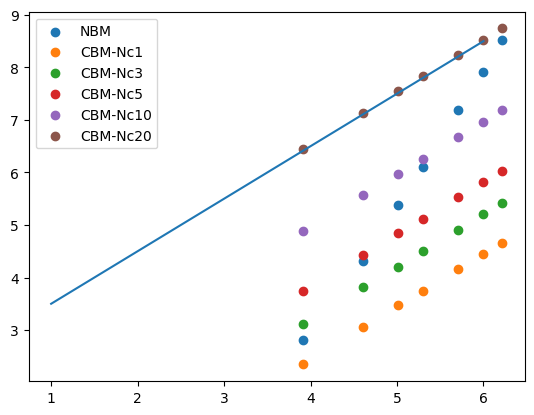

In [183]:
fig1, ax1 = plt.subplots()

# Constructing the data
mean_data = {}

for key in keys:
    d = np.empty([0, 2])
    for N, result in results.run_results.items(): #system size
        d = np.vstack(
            [d, [N, np.mean(result.sim_results[key].time_per_iteration)]], # append a point
        )
        print(key, np.mean(result.sim_results[key].get_delta()))
    mean_data[key] = d

    ax1.scatter(np.log(system_sizes), np.log(d[:,1]), label=key)
    # ax1.scatter(system_sizes, d, label=key)
#ax1.boxplot(d)

ax1.legend()

xrange = np.linspace(1, 6)
y = xrange

ax1.plot(xrange, y + 2.5)

plt.show()    
    

## Fitting the data
Using the data in log, we can perform a linear regression on the points for each solver's result. 

In [167]:
from scipy import stats


def linfunc(x, slope, intercept):
  return slope * x + intercept


NBM       2.5
CBM-Nc1   1.01
CBM-Nc3   1.0
CBM-Nc5   0.99
CBM-Nc10  1.0
CBM-Nc20  1.0


/tmp/ipykernel_479584/853764667.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


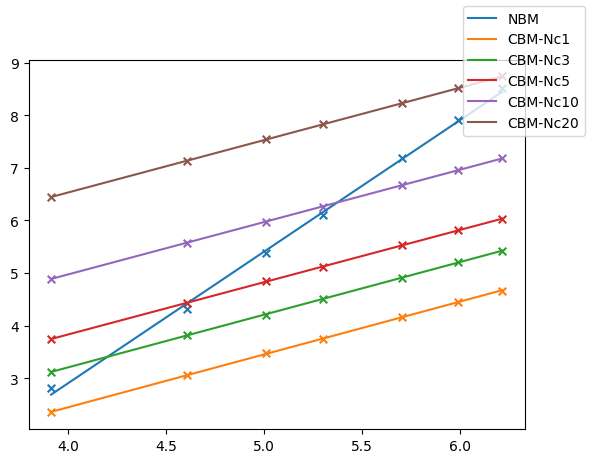

In [179]:
fig2, ax2 = plt.subplots()
# params
show_points = True

slopes = dict()

for key in keys:
  data = np.log(mean_data[key])

  slopes[key], intercept, r, p, std_err = stats.linregress(data[:,0], data[:,1])

  xmin = np.min(data[:,0])
  xmax = np.max(data[:,0])
  x_points = np.array([xmin, xmax])
  
  ax2.plot(x_points, linfunc(
    x=x_points, 
    slope=slopes[key], 
    intercept=intercept
  ),
    label = key,
    #linestyle="dashed"
  )
  
  if show_points:
    ax2.scatter(
      data[:,0], 
      data[:,1], 
      marker="x",
      s=30,
    )

for key, slope in slopes.items():
  print("{0:10}{1}".format(key, round(slope, 2)))

fig2.legend()
fig2.show()

